In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile, os

# Paths to your COCO validation images & annotations in Drive
zip_val = "/content/drive/MyDrive/infosys_ai_vision_extract/val2017.zip"
zip_ann = "/content/drive/MyDrive/infosys_ai_vision_extract/annotations_trainval2017.zip"

# Extract validation images
with zipfile.ZipFile(zip_val, 'r') as zip_ref:
    zip_ref.extractall("/content")

# Extract annotations
with zipfile.ZipFile(zip_ann, 'r') as zip_ref:
    zip_ref.extractall("/content")

print("✅ COCO val images and annotations extracted")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ COCO val images and annotations extracted


In [2]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --Model with hyperparams.ipynb


[NbConvertApp] WARNING | Unrecognized alias: 'Model', it will have no effect.
[NbConvertApp] CRITICAL | Bad config encountered during initialization: Error loading argument Model=['with'], values whose keys begin with an uppercase char must be Config instances: 'Model', DeferredConfigString('with')


In [ ]:
import cv2, glob, numpy as np, os
from pycocotools.coco import COCO
import albumentations as A

val_dir = "/content/val2017"
annFile = "/content/annotations/instances_val2017.json"
coco = COCO(annFile)

# Save folders
save_img_dir = "/content/augmented_dataset/images"
save_mask_dir = "/content/augmented_dataset/masks"
os.makedirs(save_img_dir, exist_ok=True)
os.makedirs(save_mask_dir, exist_ok=True)

resize_shape = (255,255)

# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.5)
])

val_images = sorted(glob.glob(val_dir+"/*.jpg"))

for idx, img_path in enumerate(val_images):
    img_id = int(os.path.basename(img_path).split(".")[0])
    I = cv2.imread(img_path)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((I.shape[0], I.shape[1]), dtype=np.uint8)
    for ann in anns:
        m = coco.annToMask(ann)
        mask = np.maximum(mask, m)

    I_resized = cv2.resize(I, resize_shape)
    mask_resized = cv2.resize(mask, resize_shape, interpolation=cv2.INTER_NEAREST)

    augmented = transform(image=I_resized, mask=mask_resized)
    I_aug = augmented["image"]
    mask_aug = augmented["mask"]

    cv2.imwrite(f"{save_img_dir}/aug_{idx}.jpg", cv2.cvtColor(I_aug, cv2.COLOR_RGB2BGR))
    cv2.imwrite(f"{save_mask_dir}/aug_{idx}.png", mask_aug)

print("✅ Augmented dataset created: /content/augmented_dataset")


loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


✅ Augmented dataset created: /content/augmented_dataset


In [ ]:
# ======================================
# 1. Install segmentation_models_pytorch
# ======================================
!pip install -q segmentation-models-pytorch

# ======================================
# 2. Imports
# ======================================
import os, cv2, numpy as np, random
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import segmentation_models_pytorch as smp

In [ ]:
# ======================================
# 3. Dataset Class
# ======================================
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(128, 128)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.img_size = img_size

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))
        img = torch.tensor(img, dtype=torch.float32)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask


In [ ]:
# ======================================
# 4. Losses and Metrics
# ======================================
class DiceLoss(nn.Module):
    def forward(self, preds, targets, smooth=1e-6):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        return 1 - (2 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def combined_loss(preds, targets):
    return nn.BCEWithLogitsLoss()(preds, targets) + DiceLoss()(preds, targets)

def iou_pytorch(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection / union).item() if union > 0 else 1.0


In [ ]:
# ======================================
# 5. Training Function with progress bars
# ======================================
def train_deeplab(lr, batch_size, num_epochs, subset_fraction=0.3, patience=3):
    dataset = SegmentationDataset("/content/augmented_dataset/images",
                                  "/content/augmented_dataset/masks")

    subset_size = int(len(dataset) * subset_fraction)
    subset_idx = random.sample(range(len(dataset)), subset_size)

    train_idx, val_idx = train_test_split(subset_idx, test_size=0.2, random_state=42)
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, val_idx), batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_iou = 0
    no_improve = 0

    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train()
        train_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for imgs, masks in train_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = combined_loss(preds, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_bar.set_postfix(loss=train_loss/len(train_loader))

        # ---------- Validation ----------
        model.eval()
        val_iou = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ")
        with torch.no_grad():
            for imgs, masks in val_bar:
                imgs, masks = imgs.to(device), masks.to(device)
                preds = model(imgs)
                val_iou += iou_pytorch(preds, masks)
                val_bar.set_postfix(val_iou=val_iou/len(val_loader))
        val_iou /= len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} finished. Validation IoU: {val_iou:.4f}")

        # ---------- Early stopping ----------
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), "best_deeplab.pth")
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print("Early stopping...")
            break

    return best_iou

# ======================================
# 6. Random Hyperparameter Search with progress
# ======================================
def random_hyperparam_search(n_trials=5):
    lr_choices = [1e-3, 5e-4, 1e-4]
    bs_choices = [4, 8]
    ep_choices = [10, 15]

    results = []

    for _ in range(n_trials):
        lr = random.choice(lr_choices)
        bs = random.choice(bs_choices)
        ep = random.choice(ep_choices)
        print(f"\nTesting LR={lr}, BS={bs}, Epochs={ep}")
        val_iou = train_deeplab(lr, bs, ep)
        results.append({"lr": lr, "batch_size": bs, "epochs": ep, "val_iou": val_iou})

    best_config = max(results, key=lambda x: x["val_iou"])
    print("\n✅ Best Hyperparameters:")
    print(best_config)

# Run random search
random_hyperparam_search(n_trials=5)


Testing LR=0.0005, BS=8, Epochs=10


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1/10 [Val]  : 100%|██████████| 38/38 [00:32<00:00,  1.18it/s, val_iou=0.41]


Epoch 1/10 finished. Validation IoU: 0.4100


Epoch 2/10 [Val]  : 100%|██████████| 38/38 [00:32<00:00,  1.19it/s, val_iou=0.354]


Epoch 2/10 finished. Validation IoU: 0.3539


Epoch 3/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.29it/s, val_iou=0.454]


Epoch 3/10 finished. Validation IoU: 0.4539


Epoch 4/10 [Val]  : 100%|██████████| 38/38 [00:31<00:00,  1.19it/s, val_iou=0.387]


Epoch 4/10 finished. Validation IoU: 0.3866


Epoch 5/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.29it/s, val_iou=0.407]


Epoch 5/10 finished. Validation IoU: 0.4073


Epoch 6/10 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.33it/s, val_iou=0.434]


Epoch 6/10 finished. Validation IoU: 0.4337
Early stopping...

Testing LR=0.0005, BS=8, Epochs=10


Epoch 1/10 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.33it/s, val_iou=0.388]


Epoch 1/10 finished. Validation IoU: 0.3876


Epoch 2/10 [Val]  : 100%|██████████| 38/38 [00:27<00:00,  1.36it/s, val_iou=0.348]


Epoch 2/10 finished. Validation IoU: 0.3481


Epoch 3/10 [Val]  : 100%|██████████| 38/38 [00:27<00:00,  1.37it/s, val_iou=0.404]


Epoch 3/10 finished. Validation IoU: 0.4035


Epoch 4/10 [Val]  : 100%|██████████| 38/38 [00:27<00:00,  1.37it/s, val_iou=0.405]


Epoch 4/10 finished. Validation IoU: 0.4045


Epoch 5/10 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.31it/s, val_iou=0.432]


Epoch 5/10 finished. Validation IoU: 0.4321


Epoch 6/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.28it/s, val_iou=0.427]


Epoch 6/10 finished. Validation IoU: 0.4265


Epoch 7/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.29it/s, val_iou=0.439]


Epoch 7/10 finished. Validation IoU: 0.4389


Epoch 8/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.28it/s, val_iou=0.338]


Epoch 8/10 finished. Validation IoU: 0.3384


Epoch 9/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.27it/s, val_iou=0.422]


Epoch 9/10 finished. Validation IoU: 0.4221


Epoch 10/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.30it/s, val_iou=0.398]


Epoch 10/10 finished. Validation IoU: 0.3984
Early stopping...

Testing LR=0.001, BS=8, Epochs=15


Epoch 1/15 [Val]  : 100%|██████████| 38/38 [00:32<00:00,  1.16it/s, val_iou=0.398]


Epoch 1/15 finished. Validation IoU: 0.3976


Epoch 2/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, val_iou=0.414]


Epoch 2/15 finished. Validation IoU: 0.4138


Epoch 3/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.34it/s, val_iou=0.271]


Epoch 3/15 finished. Validation IoU: 0.2711


Epoch 4/15 [Val]  : 100%|██████████| 38/38 [00:32<00:00,  1.19it/s, val_iou=0.418]


Epoch 4/15 finished. Validation IoU: 0.4179


Epoch 5/15 [Val]  : 100%|██████████| 38/38 [00:40<00:00,  1.05s/it, val_iou=0.396]


Epoch 5/15 finished. Validation IoU: 0.3958


Epoch 6/15 [Val]  : 100%|██████████| 38/38 [00:31<00:00,  1.20it/s, val_iou=0.426]


Epoch 6/15 finished. Validation IoU: 0.4256


Epoch 7/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.32it/s, val_iou=0.363]


Epoch 7/15 finished. Validation IoU: 0.3626


Epoch 8/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.34it/s, val_iou=0.41]


Epoch 8/15 finished. Validation IoU: 0.4104


Epoch 9/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, val_iou=0.43]


Epoch 9/15 finished. Validation IoU: 0.4300


Epoch 10/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, val_iou=0.428]


Epoch 10/15 finished. Validation IoU: 0.4284


Epoch 11/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.36it/s, val_iou=0.447]


Epoch 11/15 finished. Validation IoU: 0.4472


Epoch 12/15 [Val]  : 100%|██████████| 38/38 [00:30<00:00,  1.26it/s, val_iou=0.449]


Epoch 12/15 finished. Validation IoU: 0.4495


Epoch 13/15 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.31it/s, val_iou=0.378]


Epoch 13/15 finished. Validation IoU: 0.3783


Epoch 14/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.33it/s, val_iou=0.457]


Epoch 14/15 finished. Validation IoU: 0.4572


Epoch 15/15 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.31it/s, val_iou=0.426]


Epoch 15/15 finished. Validation IoU: 0.4257

Testing LR=0.001, BS=4, Epochs=15


Epoch 1/15 [Val]  : 100%|██████████| 75/75 [00:32<00:00,  2.34it/s, val_iou=0.288]


Epoch 1/15 finished. Validation IoU: 0.2882


Epoch 2/15 [Val]  : 100%|██████████| 75/75 [00:32<00:00,  2.32it/s, val_iou=0.304]


Epoch 2/15 finished. Validation IoU: 0.3037


Epoch 3/15 [Val]  : 100%|██████████| 75/75 [00:30<00:00,  2.49it/s, val_iou=0.402]


Epoch 3/15 finished. Validation IoU: 0.4025


Epoch 4/15 [Val]  : 100%|██████████| 75/75 [00:34<00:00,  2.17it/s, val_iou=0.35]


Epoch 4/15 finished. Validation IoU: 0.3495


Epoch 5/15 [Val]  : 100%|██████████| 75/75 [00:29<00:00,  2.52it/s, val_iou=0.424]


Epoch 5/15 finished. Validation IoU: 0.4241


Epoch 6/15 [Val]  : 100%|██████████| 75/75 [00:34<00:00,  2.19it/s, val_iou=0.367]


Epoch 6/15 finished. Validation IoU: 0.3673


Epoch 7/15 [Val]  : 100%|██████████| 75/75 [00:29<00:00,  2.51it/s, val_iou=0.363]


Epoch 7/15 finished. Validation IoU: 0.3634


Epoch 8/15 [Val]  : 100%|██████████| 75/75 [00:32<00:00,  2.29it/s, val_iou=0.386]


Epoch 8/15 finished. Validation IoU: 0.3858
Early stopping...

Testing LR=0.0001, BS=8, Epochs=10


Epoch 1/10 [Val]  : 100%|██████████| 38/38 [00:30<00:00,  1.25it/s, val_iou=0.485]


Epoch 1/10 finished. Validation IoU: 0.4852


Epoch 2/10 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, val_iou=0.472]


Epoch 2/10 finished. Validation IoU: 0.4725


Epoch 3/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.27it/s, val_iou=0.495]


Epoch 3/10 finished. Validation IoU: 0.4955


Epoch 4/10 [Val]  : 100%|██████████| 38/38 [00:32<00:00,  1.17it/s, val_iou=0.518]


Epoch 4/10 finished. Validation IoU: 0.5180


Epoch 5/10 [Val]  : 100%|██████████| 38/38 [00:31<00:00,  1.19it/s, val_iou=0.541]


Epoch 5/10 finished. Validation IoU: 0.5413


Epoch 6/10 [Val]  : 100%|██████████| 38/38 [00:29<00:00,  1.27it/s, val_iou=0.492]


Epoch 6/10 finished. Validation IoU: 0.4919


Epoch 7/10 [Val]  : 100%|██████████| 38/38 [00:28<00:00,  1.36it/s, val_iou=0.527]


Epoch 7/10 finished. Validation IoU: 0.5274


Epoch 8/10 [Val]  : 100%|██████████| 38/38 [00:34<00:00,  1.09it/s, val_iou=0.494]

Epoch 8/10 finished. Validation IoU: 0.4937
Early stopping...

✅ Best Hyperparameters:
{'lr': 0.0001, 'batch_size': 8, 'epochs': 10, 'val_iou': 0.5412833416148236}


In [ ]:
# =============================
# Function to check Accuracy & IoU
# =============================
def pixel_accuracy(preds, masks):
    preds = torch.sigmoid(preds) > 0.5   # convert logits → binary mask
    correct = (preds == masks.bool()).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

def evaluate_model(model_path, dataset, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights=None,   # no pretrained weights when loading
        in_channels=3,
        classes=1
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # DataLoader
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    total_iou, total_acc = 0, 0
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Testing"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)

            total_iou += iou_pytorch(preds, masks)
            total_acc += pixel_accuracy(preds, masks)

    avg_iou = total_iou / len(test_loader)
    avg_acc = total_acc / len(test_loader)
    print(f"\n✅ Test IoU: {avg_iou:.4f}, Test Accuracy: {avg_acc:.4f}")
    return avg_iou, avg_acc


# =============================
# Example usage (after training)
# =============================
# Reload your dataset (or make a test split if you have one)
test_dataset = SegmentationDataset("/content/augmented_dataset/images",
                                   "/content/augmented_dataset/masks")

# Evaluate
evaluate_model("best_deeplab.pth", test_dataset, batch_size=4)


Testing: 100%|██████████| 1250/1250 [09:04<00:00,  2.30it/s]


✅ Test IoU: 0.5461, Test Accuracy: 0.8305


(0.5461156409472228, 0.8304753540039063)

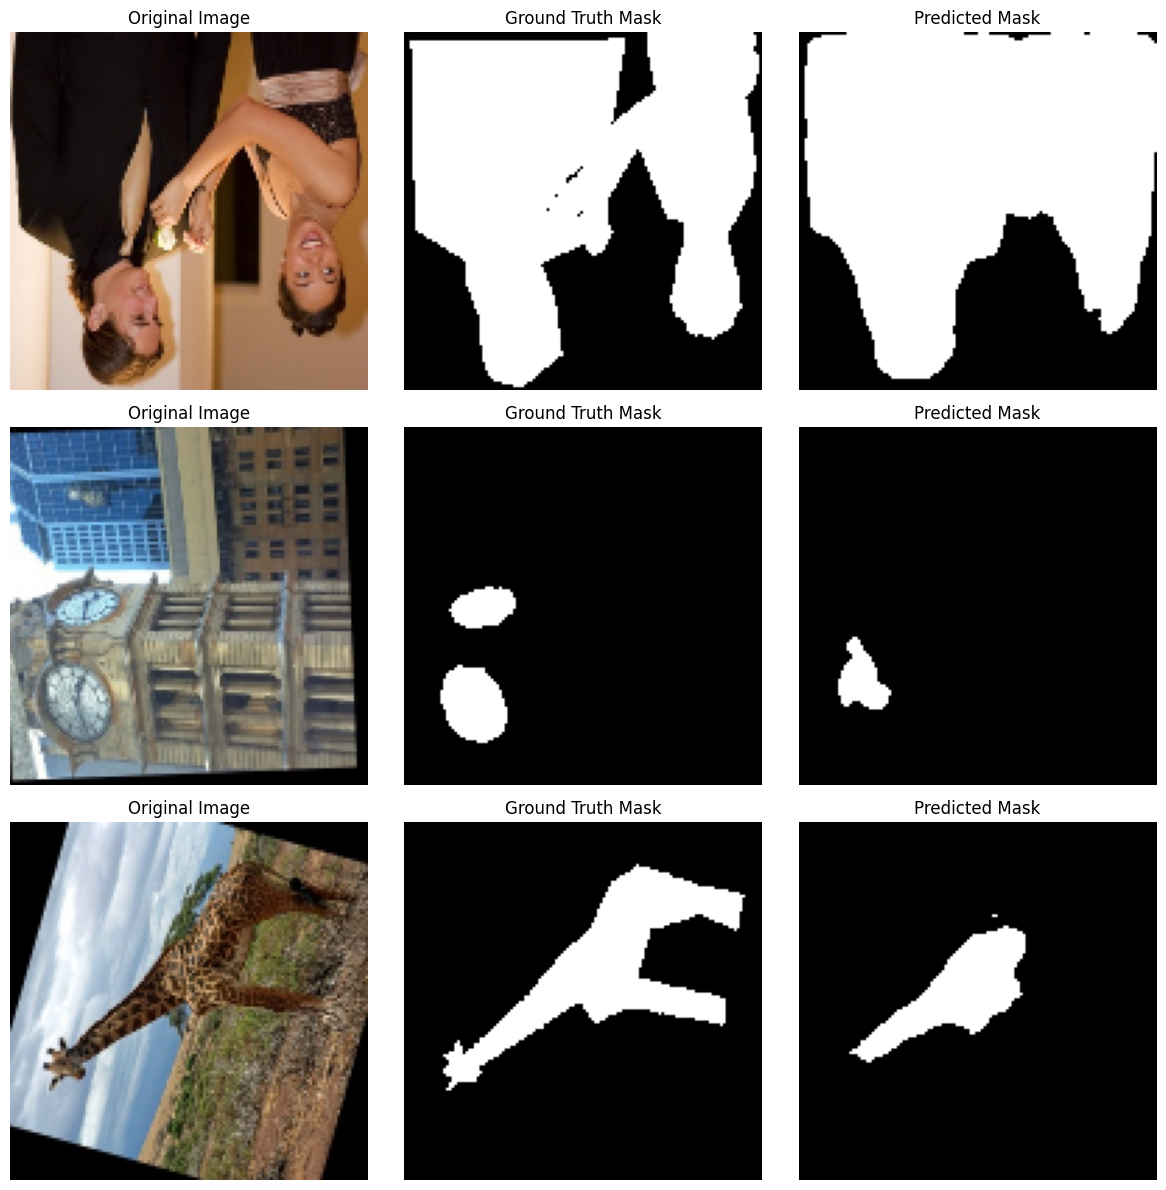

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model_path, dataset, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights=None,
        in_channels=3,
        classes=1
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Randomly pick samples
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(12, num_samples * 4))
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)  # add batch dim
        with torch.no_grad():
            pred = model(img_tensor)
            pred_mask = (torch.sigmoid(pred) > 0.5).squeeze().cpu().numpy()

        # Convert back to numpy for visualization
        img_np = img.permute(1, 2, 0).numpy()  # (H, W, C)
        mask_np = mask.squeeze().numpy()

        # Plot original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis("off")

        # Plot ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Plot predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example usage
visualize_predictions("best_deeplab.pth", test_dataset, num_samples=3)


Testing: 100%|██████████| 1250/1250 [09:05<00:00,  2.29it/s]



✅ Test IoU: 0.5461, Test Accuracy: 0.8305


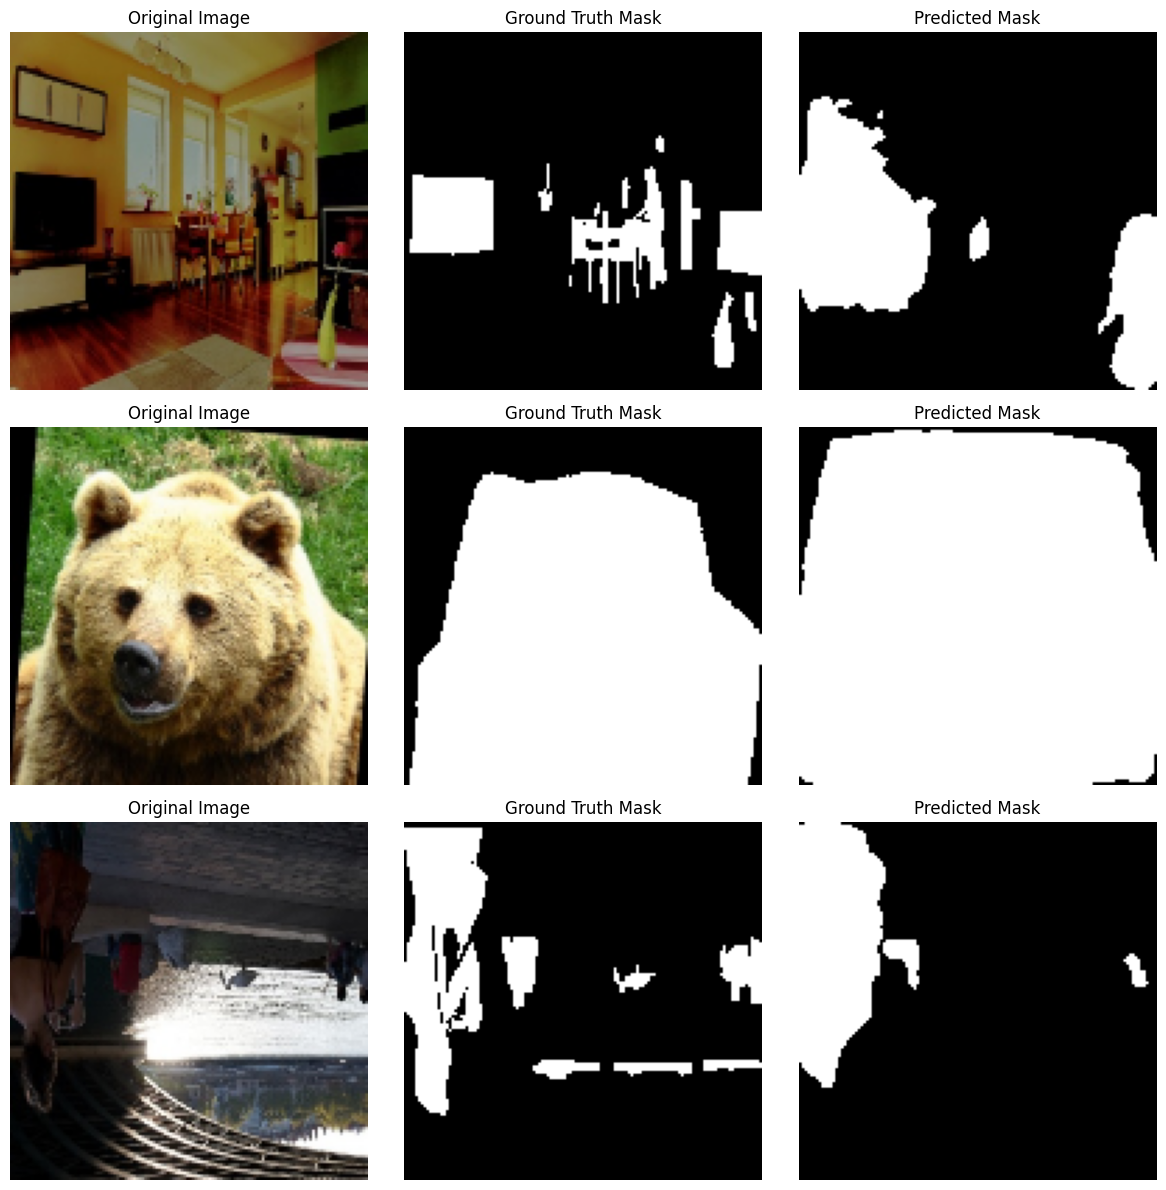

(0.5461156409472228, 0.8304753540039063)

In [ ]:
import matplotlib.pyplot as plt

def pixel_accuracy(preds, masks):
    preds = torch.sigmoid(preds) > 0.5   # convert logits → binary mask
    correct = (preds == masks.bool()).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

def evaluate_model(model_path, dataset, batch_size=4, num_samples=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights=None,   # no pretrained weights when loading
        in_channels=3,
        classes=1
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # DataLoader
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    total_iou, total_acc = 0, 0
    all_preds, all_imgs, all_masks = [], [], []

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Testing"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)

            total_iou += iou_pytorch(preds, masks)
            total_acc += pixel_accuracy(preds, masks)

            # Save some samples for visualization
            if len(all_imgs) < num_samples:
                all_imgs.extend(imgs.cpu())
                all_masks.extend(masks.cpu())
                all_preds.extend(preds.cpu())

    avg_iou = total_iou / len(test_loader)
    avg_acc = total_acc / len(test_loader)
    print(f"\n✅ Test IoU: {avg_iou:.4f}, Test Accuracy: {avg_acc:.4f}")

    # ===============================
    # 🔍 Show Original vs Ground Truth vs Prediction
    # ===============================
    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        img = all_imgs[i]
        mask = all_masks[i]
        pred = all_preds[i]

        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().numpy()
        pred_np = (torch.sigmoid(pred) > 0.5).squeeze().numpy()

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_np, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return avg_iou, avg_acc


# Example usage
test_dataset = SegmentationDataset("/content/augmented_dataset/images",
                                   "/content/augmented_dataset/masks")
evaluate_model("best_deeplab.pth", test_dataset, batch_size=4, num_samples=3)
